# Build a RAG application with Elasticsearch's semantic_text and Amazon Bedrock


## Introduction

In this notebook we will show you how to use the the `semantic_text` mapping type in Elasticsearch along with Amazon Bedrock, Anthropic Claude 3.7, and Langchain to build a Retrieval Augmented Generation (RAG) solution.

The semantic_text field type *automatically* generates embeddings for text content using an inference endpoint. Long passages are [automatically chunked](https://www.elastic.co/guide/en/elasticsearch/reference/current/semantic-text.html#auto-text-chunking) to smaller sections to enable the processing of larger corpuses of text. This mapping type was designed to simplify common challenges of building a RAG application and brings together the steps of chunking text, generating embeddings, and then retrieving them.

You can find documentation on the [semantic_text](https://www.elastic.co/guide/en/elasticsearch/reference/master/semantic-text.html) field type here to quickly get started with semantic search.

You can see [a more detailed lab](https://www.elastic.co/search-labs/blog/semantic-search-simplified-semantic-text) here as well.

#### Use case

To demonstrate the RAG capability, let's take the use case of an AI Assistant that can help answer questions from a personal document. 


#### Persona
You are Bob,an Application Developer at Anycompany. Anycompany is experiencing an overwhelming number of customer queries. Anycompany has built a secure and performant conversational AI Assistant to answer frequently asked questions. Now Anycompany wants this conversational AI assistant to be able to answer questions are which are specific to the company. 

In this workshop, you will build a context aware conversational AI Assistant for Anycompany with help from the `semantic_text` mapping type in Elastic.

#### Implementation
To fulfill this use case, in this notebook we will show how to create a RAG Application using the `semantic_text` mapping to answer questions from business data. We will use  Elasticsearch, Anthropic Claude 3.7 Sonnet Foundation model, Amazon Bedrock and Langchain. 

#### Implementation
We're using an Elastic Serverless deployment of Elasticsearch for this notebook. If you don't have an Elastic Cloud account, sign up [here](https://cloud.elastic.co/serverless-registration?onboarding_token=vectorsearch) for a free trial. Once you've signed up, you can create your Elasticsearch API Key following the documentation [here](https://www.elastic.co/docs/current/serverless/api-keys). 

## Additional guidance for running this lab in Elastic directly using the Dev Tools interface in Kibana instead of in a Jupyter notebook is [here]([https://www.elastic.co/search-labs/blog/semantic-text-with-amazon-bedrock](https://www.elastic.co/search-labs/blog/semantic-text-with-amazon-bedrock)).

You can see the high-level architecture of how an integration of Amazon Bedrock with Elastic's semantic_text field works below:

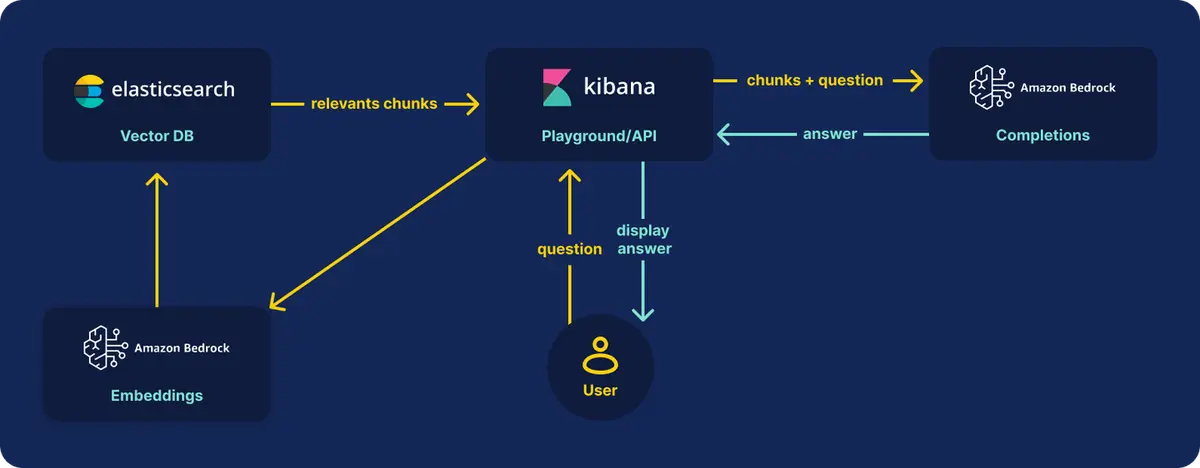


In [ ]:
%pip install --upgrade pip
%pip install boto3 --force-reinstall --quiet
%pip install botocore --force-reinstall --quiet
%pip install elasticsearch==8.18.0 --force-reinstall --quiet

## Kernel Restart

Restart the kernel with the updated packages that are installed through the dependencies above

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Next, we need to import the modules we need. 

In [ ]:
from elasticsearch import Elasticsearch, exceptions
from urllib.request import urlopen
from getpass import getpass
import json
import time
import json
import os
import sys
import boto3
import botocore
from pprint import pprint

Now we can instantiate the Python Elasticsearch client.

First we will be prompted for our API key and Cloud ID. Please refer to the "elastic-bedrock-claude-langchain-rag" notebook in this lab for instructions on how to pull those from Elastic. Alternatively, read [Elastic's documentation](https://www.elastic.co/guide/en/elasticsearch/client/python-api/current/connecting.html#connect-self-managed-new) to learn how to connect using API keys.

Then we create a `client` object that instantiates an instance of the `Elasticsearch` class.

In [ ]:
# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#finding-your-cloud-id
ELASTIC_CLOUD_ID = getpass("Elastic deployment Cloud ID: ")

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = getpass("Elastic deployment API Key: ")

# Create the client instance
client = Elasticsearch(
    # For local development
    # hosts=["http://localhost:9200"]
    cloud_id=ELASTIC_CLOUD_ID,
    api_key=ELASTIC_API_KEY,
)

### Test the Client
Before you continue, confirm that the client has connected with this test.

In [ ]:
print(client.info())

### If not using serverless, expand this section 

Follow the instructions below to ensure ML Nodes are available

#### *If using serverless, you can skip to the "Create Inference Endpoint" section below.*

First go to the "Edit" section in "My deployment" on Elastic Cloud:

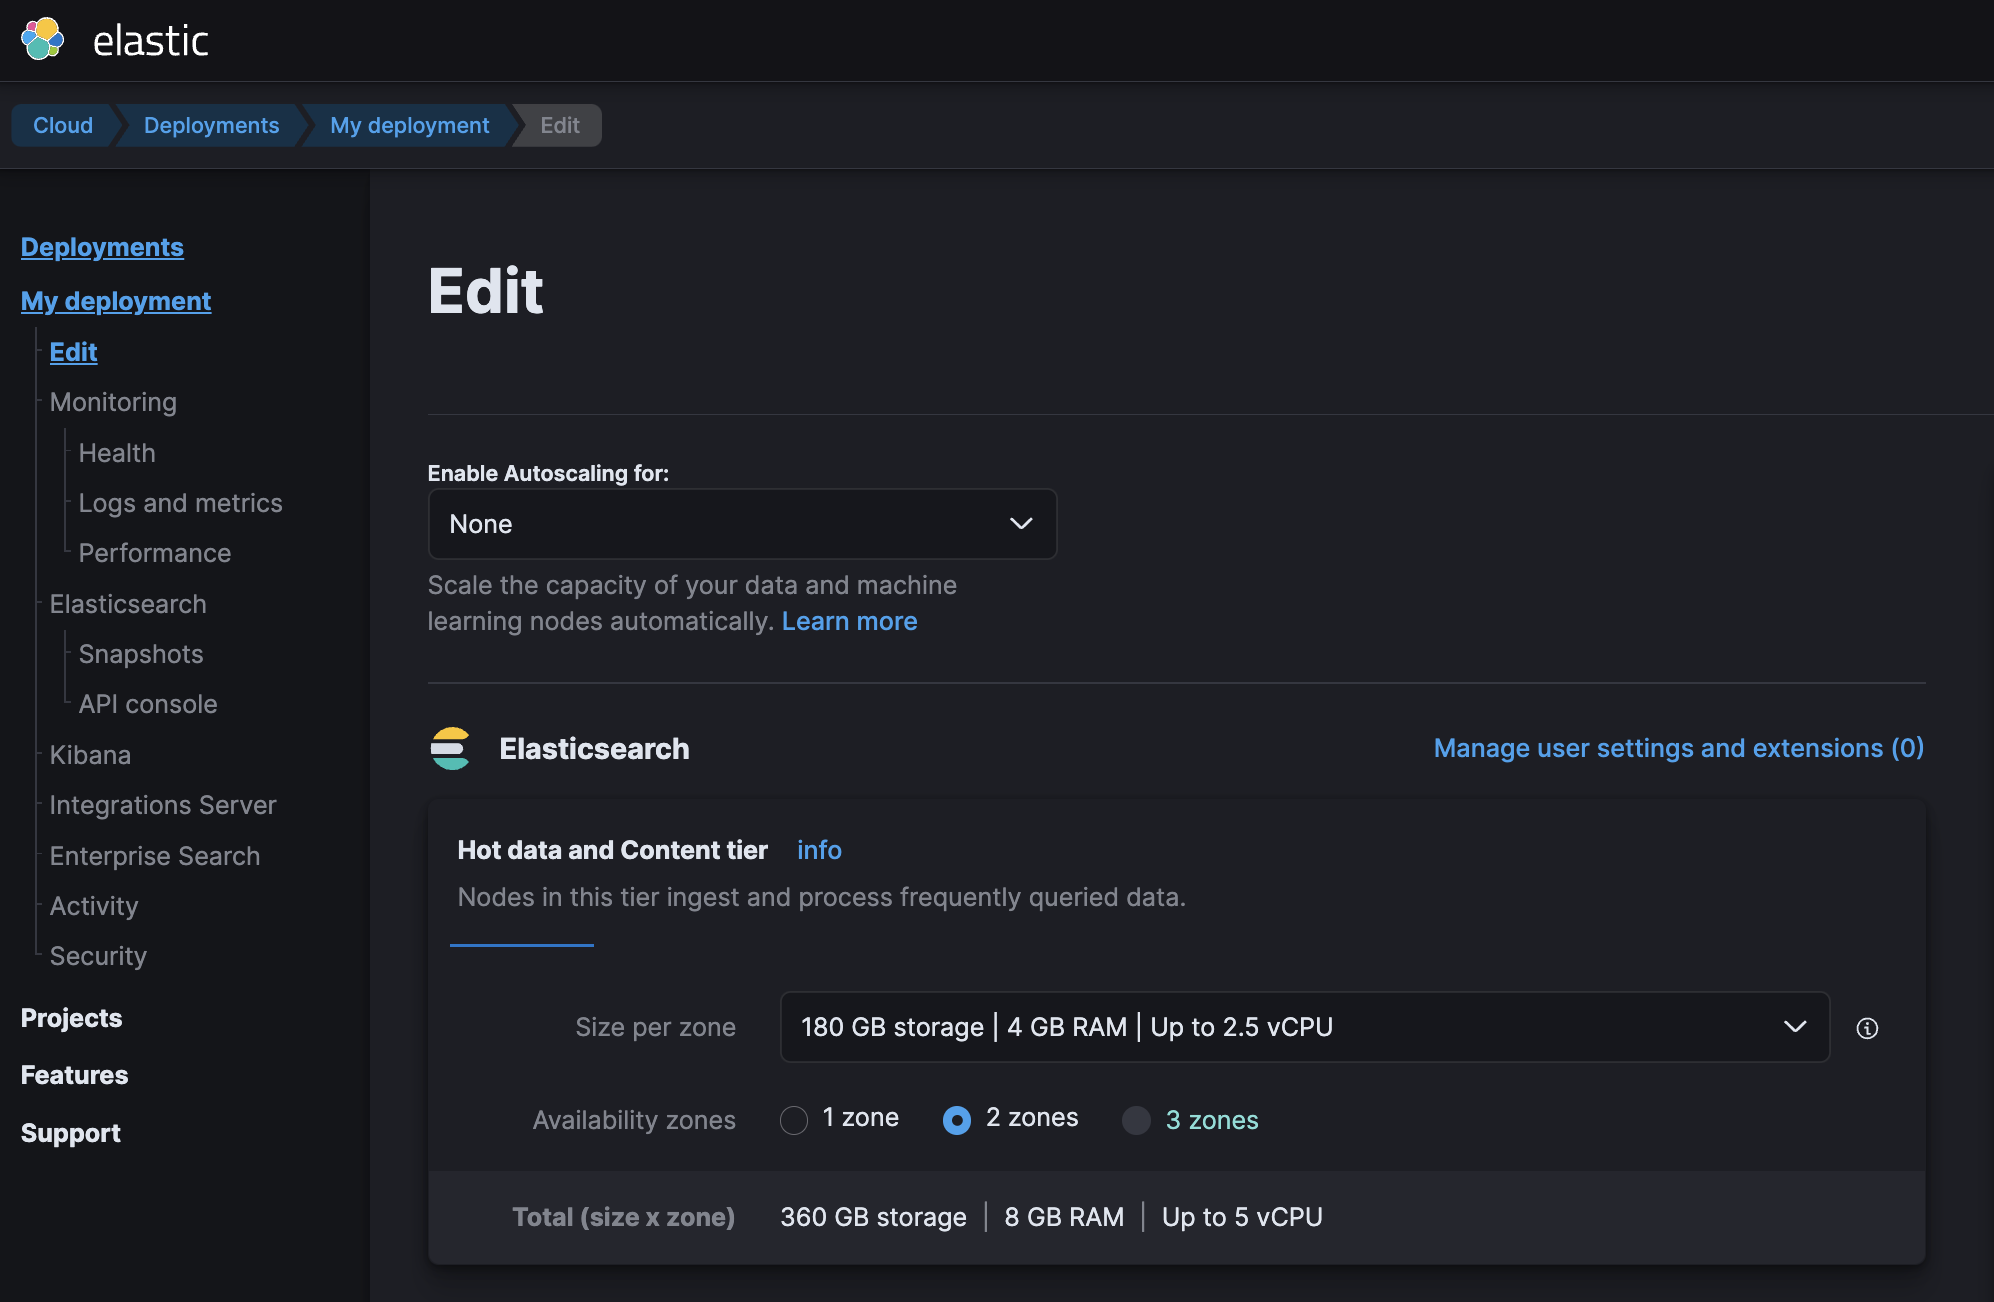

Then, scroll down to the machine learning section and select the following:

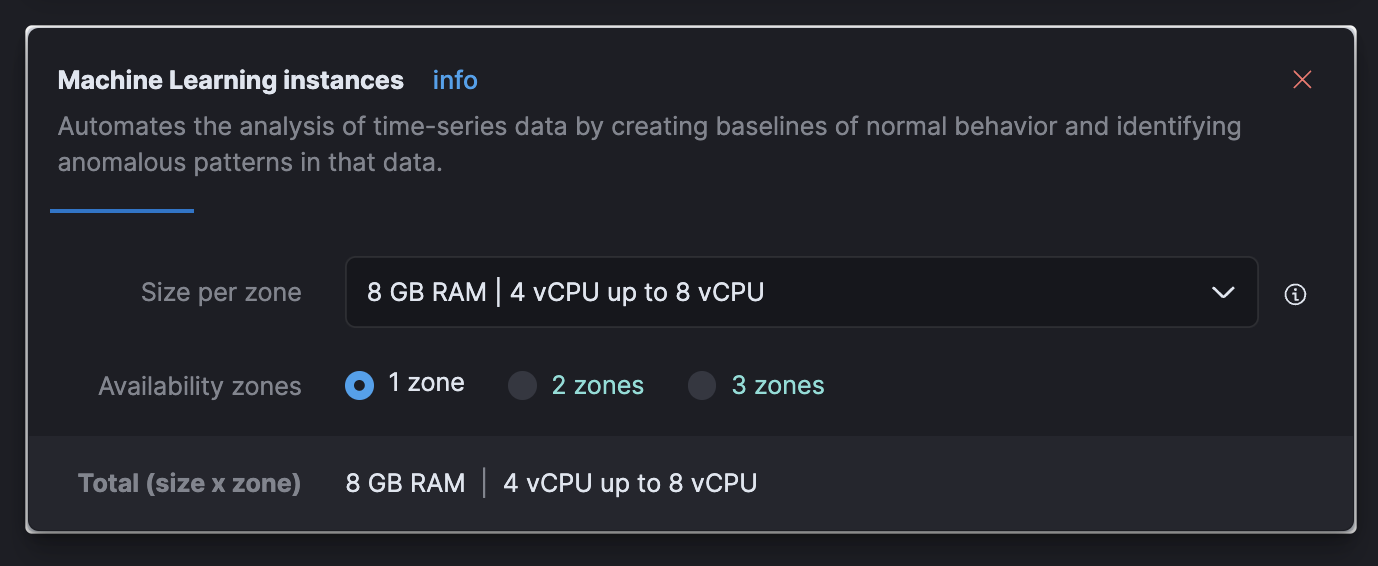


And confirm. Now you're good to go!

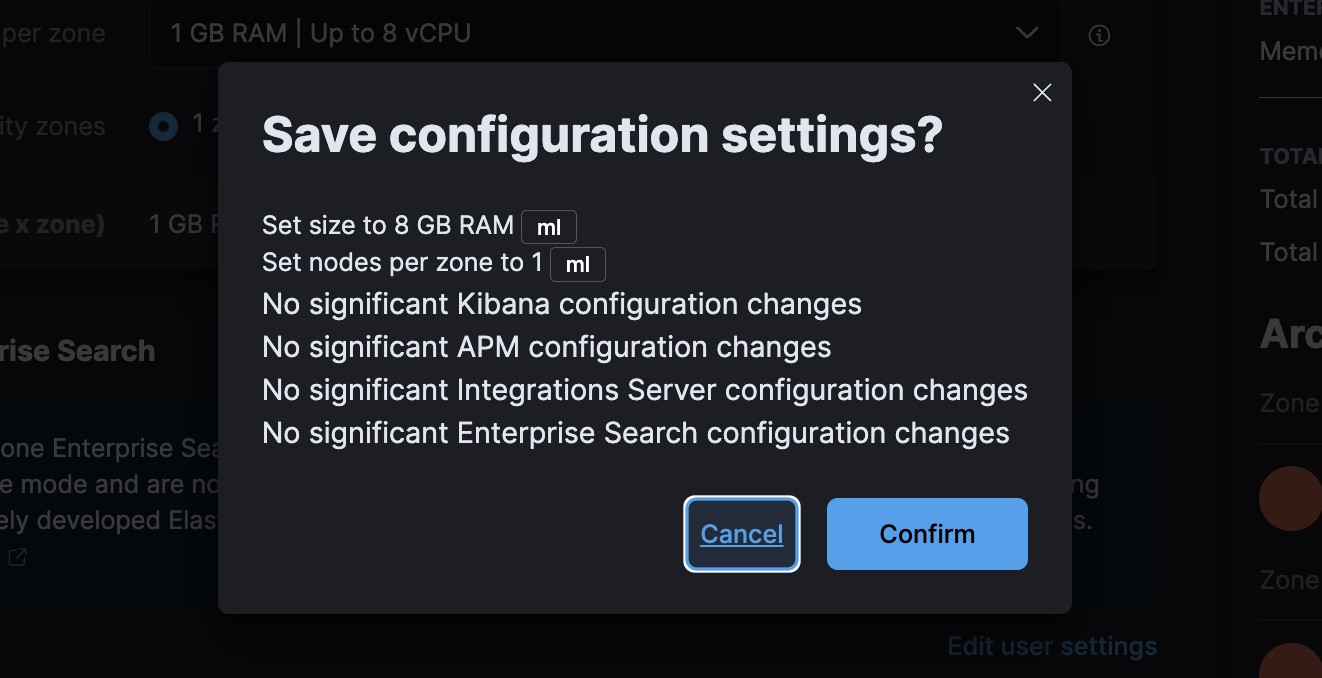


##  Create Inference Endpoint 

The `semantic_text` field type specifies an inference endpoint identifier that will be used to generate embeddings automatically. We will create the inference endpoint by using the [Create inference API](https://www.elastic.co/guide/en/elasticsearch/reference/current/put-inference-api.html).

For our embeddings task, we will use Elastic's own [ELSER service](https://www.elastic.co/guide/en/machine-learning/current/ml-nlp-elser.html) for this. We could also use Elastic's [Amazon Bedrock Integration](https://www.elastic.co/guide/en/integrations/current/aws_bedrock.html) like we do in the other notebooks.

The code block below will take care of this; if you want to do this from Kibana in Elastic directly, you can follow the instructions here: [Download and deploy ELSER](https://www.elastic.co/guide/en/machine-learning/master/ml-nlp-elser.html#download-deploy-elser). 

In [ ]:
model_id = ".elser_model_2"
task_type = "sparse_embedding"
inference_id = "my-elser-model"

If you get an error, check the model has been deployed and is available in the ML node. In newer versions of Elastic Cloud, ML node is autoscaled and the ML node may not be ready yet. Wait for a few minutes and try again.

In [ ]:
# if this cell times out, run it again.

try:
    # Try to get the inference endpoint
    response = client.inference.get(task_type=task_type, inference_id=inference_id)
    pprint(f"Inference endpoint exists: {response}")
    
except exceptions.NotFoundError:
    # If the inference endpoint is not found, put the inference configuration
    response = client.inference.put(
        task_type=task_type,
        inference_id=inference_id,
        inference_config={
            "service": "elasticsearch",
            "service_settings": {
                "num_allocations": 1,
                "num_threads": 1,
                "model_id": model_id
            }
        },
    )
    pprint(f"Inference configuration response: {response}")

The above command will download the ELSER model. This will take a few minutes to complete. Use the following command to check the status of the model download.

In [ ]:
while True:
    status = client.ml.get_trained_models(
        model_id=".elser_model_2", include="definition_status"
    )

    if status["trained_model_configs"][0]["fully_defined"]:
        print("ELSER Model is downloaded and ready to be deployed.")
        break
    else:
        print("ELSER Model is downloaded but not ready to be deployed.")
    time.sleep(5)

In [ ]:
# if it's ready to be deployed, let's deploy it!
try:
    response = client.ml.start_trained_model_deployment(model_id=model_id)
    pprint(f"Model started successfully: {response}")
except Exception as e:
    print("Error starting model:", e)

## Creating mappings

Great! Your Elastic cluster now has an embeddings inference endpoint called `my-elser-model.`

Let's use this mapping type in a new index called "semantic-text-movies"

The new `semantic_text` mapping type will make things super easy. It will take care of inferring the embedding mappings and configurations, and doing the passage chunking for you!

In [ ]:
# delete if exists already:
client.indices.delete(index="semantic-text-movies", ignore_unavailable=True)

# Define the index name and mappings
index_name = "semantic-text-movies"
mappings = {
    "mappings": {
        "properties": {
            "title": {"type": "text"},
            "genre": {"type": "text"},
            "plot": {"type": "text", "copy_to": "plot_semantic"},
            "plot_semantic": {
                "type": "semantic_text",
                "inference_id": inference_id,
            },
        }
    }
}

# Create the index with the specified mappings
try:
    response = client.indices.create(index=index_name, body=mappings)
    print(f"Index '{index_name}' created successfully.")
except exceptions.RequestError as e:
    if e.error == "resource_already_exists_exception":
        print(f"Index '{index_name}' already exists.")
    else:
        raise e
except Exception as e:
    print(f"An error occurred: {e}")

YES! That's it. plot_semantic is ready to be searched with vectors, and to handle chunking.

Notice how we configured the mappings. We defined `plot_semantic` as a `semantic_text` field.
The `inference_id` parameter defines the inference endpoint that is used to generate the embeddings for the field.
Then we configured the `plot` field to [copy its value](https://www.elastic.co/guide/en/elasticsearch/reference/current/copy-to.html) to the `plot_semantic` field.

## Populate the Index

Let's populate the index with an example dataset of 12 movies.

In [ ]:
url = "https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/notebooks/search/movies.json"
response = urlopen(url)
movies = json.loads(response.read())

operations = []
for movie in movies:
    operations.append({"index": {"_index": "semantic-text-movies"}})
    operations.append(movie)
client.bulk(index="semantic-text-movies", operations=operations, refresh=True)

## Semantic Search

Now that our index is populated, we can query it using semantic search.

### Aside: Pretty printing Elasticsearch search results

Your `search` API calls will return hard-to-read nested JSON.
We'll create a little function called `pretty_search_response` to return nice, human-readable outputs from our examples.

In [ ]:
def pretty_search_response(response):
    if len(response["hits"]["hits"]) == 0:
        print("Your search returned no results.")
    else:
        for hit in response["hits"]["hits"]:
            id = hit["_id"]
            score = hit["_score"]
            title = hit["_source"]["title"]
            runtime = hit["_source"]["runtime"]
            plot = hit["_source"]["plot"]
            keyScene = hit["_source"]["keyScene"]
            genre = hit["_source"]["genre"]
            released = hit["_source"]["released"]

            pretty_output = f"\nID: {id}\nScore: {score}\nTitle: {title}\nRuntime: {runtime}\nPlot: {plot}\nKey Scene: {keyScene}\nGenre: {genre}\nReleased: {released}"

            print(pretty_output)

### Semantic Search with the `semantic` Query

We can use the [`semantic` query](https://www.elastic.co/guide/en/elasticsearch/reference/master/query-dsl-semantic-query.html) to quickly & easily query the `semantic_text` field in our index.
Under the hood, an embedding is automatically generated for our query text using the `semantic_text` field's inference endpoint.

In [ ]:
response = client.search(
    index="semantic-text-movies",
    query={"semantic": {"field": "plot_semantic", "query": "organized crime movies"}},
)

pretty_search_response(response)

These results demonstrate the power of semantic search using the `semantic_text` field.
Our top results are all movies involving organized crime, even if the exact term "organized crime" doesn't appear in the plot description.
This works because the embeddings model understands the semantic similarity between terms like "organized crime" and "mob".

However, these results also show the weaknesses of semantic search.
Because semantic search is based on vector similarity, there is a long tail of results that are weakly related to our query vector.
That's why movies like _The Matrix_ are returned towards the tail end of our search results.

### Hybrid Search with the `semantic` Query

We can address some of the issues with pure semantic search by combining it with lexical search techniques.
Here, we use a [boolean query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-bool-query.html) to require that all matches contain at least term from the query text, in either the `plot` or `genre` fields.

In [ ]:
response = client.search(
    index="semantic-text-movies",
    query={
        "bool": {
            "must": {
                "multi_match": {
                    "fields": ["plot", "genre"],
                    "query": "organized crime movies",
                    "boost": 1.5,
                }
            },
            "should": {
                "semantic": {
                    "field": "plot_semantic",
                    "query": "organized crime movies",
                    "boost": 3.0,
                }
            },
        }
    },
)

pretty_search_response(response)

These results demonstrate that the application of lexical search techniques can help focus the results, while retaining many of the advantages of semantic search.
In this example, the top search results are all still movies involving organized crime, but the `multi_match` query keeps the long tail shorter and focused on movies in the crime genre.

Note the `boost` parameters applied to the `multi_match` and `semantic` queries.
Combining lexical and semantic search techniques in a boolean query like this is called "linear combination" and when doing this, it is important to normalize the scores of the component queries.
This involves consideration of a few factors, including:

- The range of scores generated by the query
- The relative importance and accuracy of the query in the context of the dataset

In this example, the `multi_match` query is mostly used as a filter to constrain the search results' long tail, so we assign it a lower boost than the `semantic` query.

# Asking questions
It's nice to see how the semantic search and hybrid search functionality works, but we want to simply ask questions.

If we were to use this to make a chatbot, we know that the question and answer is a two step process. First we must retrieve the text chunks relevant to the question, and then we would send the chunks to the LLM to generate the answer. 

Thankfully, our `semantic_text` field has taken care of creating the chunks so that we can decide how we want to handle those chunks in our RAG pipeline.

We will explore two strategies to do that, as promised, without any additional code or frameworks.

# Strategy 1: API Calls

We can make an API call to the `_search` endpoint to retrieve the chunk.

### Retrieving chunks

We are going to try a small query about these movies to make sure the answer from the LLM is obtained from our movie dataset, and not from the LLM base knowledge. 

We can start with a nice and short default query for semantic_text:

In [ ]:
# this will return the 3 most relevant hits

response = client.search(
    index="semantic-text-movies",
    query={"semantic": {"field": "plot_semantic", "query": "which movies are about hitmen?"}},size=3
)

pretty_search_response(response)

Read more about the `semantic_text` field in [Elastic's docs](https://www.elastic.co/guide/en/elasticsearch/reference/current/semantic-text.html). What other strategies can you apply?

# Strategy 2: Playground

Now that you have learned how things work internally, let me show you how you can do this nice and easy, and with a nice UI on top. Using Elastic Playground.

Go to Playground, configure the Bedrock connector, and then select the index we just created and you are ready to go.

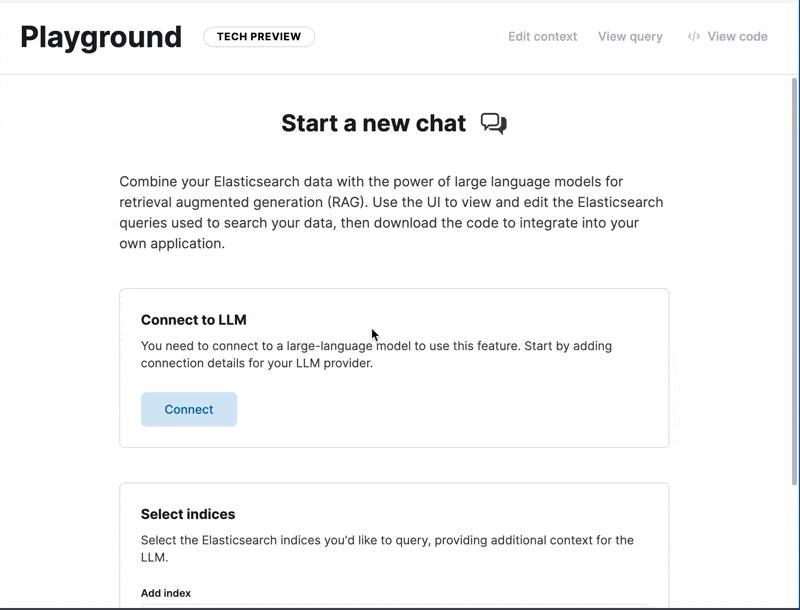


# Conclusion

The [semantic_text](https://www.elastic.co/guide/en/elasticsearch/reference/master/semantic-text.html) field type is a powerful tool that can help you quickly and easily integrate semantic search.
It can greatly improve the relevancy of your search results, particularly when combined with lexical search techniques.